In [ ]:
# design input layer and classifier

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
## load data

In [2]:
# data augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # 資料增補
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 使用 ImageFolder 可方便轉換為 dataset
data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

# 取得資料筆數
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# 取得類別
class_names = image_datasets['train'].classes

In [3]:
dataset_sizes

{'train': 244, 'val': 153}

In [4]:
# check gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cpu'

## 顯示資料增補的圖像

In [6]:
# show data augmentation picture
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# 取得一批資料
inputs, classes = next(iter(dataloaders['train']))

# 顯示一批資料
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

: 

: 

## 定義模型訓練函數

In [5]:
# 同時含訓練/評估
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # 逐批訓練或驗證
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # 訓練時需要梯度下降
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 訓練時需要 backward + optimize
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 統計損失
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 如果是評估階段，且準確率創新高即存入 best_model_wts
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 載入最佳模型
    model.load_state_dict(best_model_wts)
    return model

## 定義顯示預測結果的函數

In [6]:
def imshow2(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                plt.subplot(num_images//4+1, 4, images_so_far)
                plt.axis('off')
                plt.title(class_names[preds[j]])
                imshow2(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
    plt.tight_layout()    
    plt.show()

## 自訂辨識層

In [8]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# 改為自訂辨識層
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

# 定義損失函數
criterion = nn.CrossEntropyLoss()

# 定義優化器
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 每7個執行週期，學習率降 0.1
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

c:\Users\a4022\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\a4022\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\a4022/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 32.4MB/s]


In [9]:
model_ft.modules

<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

## 訓練：CPU訓練時間約需15~20分鐘

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5424 Acc: 0.7336
val Loss: 0.3444 Acc: 0.8431

Epoch 1/24
----------
train Loss: 0.7137 Acc: 0.7623
val Loss: 0.3056 Acc: 0.8758

Epoch 2/24
----------
train Loss: 0.4768 Acc: 0.7951
val Loss: 0.1716 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.6332 Acc: 0.7541
val Loss: 0.3430 Acc: 0.8758

Epoch 4/24
----------
train Loss: 0.3462 Acc: 0.8402
val Loss: 0.4207 Acc: 0.8627

Epoch 5/24
----------
train Loss: 0.3795 Acc: 0.8607
val Loss: 0.2513 Acc: 0.9085

Epoch 6/24
----------
train Loss: 0.5766 Acc: 0.8156
val Loss: 0.3372 Acc: 0.8889

Epoch 7/24
----------
train Loss: 0.4421 Acc: 0.8115
val Loss: 0.2163 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.4147 Acc: 0.8238
val Loss: 0.1935 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3321 Acc: 0.8525
val Loss: 0.1792 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.2932 Acc: 0.8648
val Loss: 0.1852 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2811 Acc: 0.8934
val Loss: 0.2257 Acc: 0.9085

Ep

## 顯示預測結果

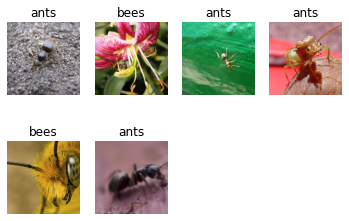

In [46]:
visualize_model(model_ft)

## 設定預先訓練的模型不用重新訓練，CPU訓練時間可以減半

In [47]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    # 不用重新訓練
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

# 定義損失函數
criterion = nn.CrossEntropyLoss()

# 定義優化器
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

# 每7個執行週期，學習率降 0.1
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)


Epoch 0/24
----------
train Loss: 0.6654 Acc: 0.6475
val Loss: 0.2450 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.4087 Acc: 0.7951
val Loss: 0.4121 Acc: 0.7974

Epoch 2/24
----------
train Loss: 0.4980 Acc: 0.7418
val Loss: 0.4285 Acc: 0.8301

Epoch 3/24
----------
train Loss: 0.5866 Acc: 0.7623
val Loss: 0.2402 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.3932 Acc: 0.8566
val Loss: 0.4330 Acc: 0.8301

Epoch 5/24
----------
train Loss: 0.3748 Acc: 0.8443
val Loss: 0.3219 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.4919 Acc: 0.7910
val Loss: 0.1925 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3145 Acc: 0.8566
val Loss: 0.2025 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.3978 Acc: 0.8320
val Loss: 0.2267 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3721 Acc: 0.8484
val Loss: 0.2167 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.2989 Acc: 0.8689
val Loss: 0.1879 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.3771 Acc: 0.8525
val Loss: 0.2259 Acc: 0.9281

Ep

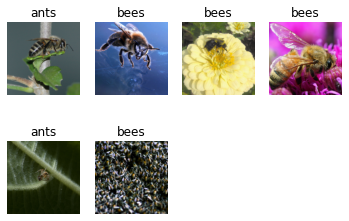

In [48]:
visualize_model(model_conv)

Further Learning
-----------------

If you would like to learn more about the applications of transfer learning,
checkout our `Quantized Transfer Learning for Computer Vision Tutorial <https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html>`_.



